In [59]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as c
from astropy.table import Table
import numpy as np
from matplotlib import colors
import lmfit
import glob
from lmfit.models import GaussianModel, SplineModel, PolynomialModel
import pandas as pd

In [175]:
def plot_data(obj,percentile = [1, 99],use_log = False):
    if(use_log):
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])),norm=colors.LogNorm())
    else:
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])))
    plt.colorbar()

def read_file(file_name):
    return np.flip(fits.open(file_name)['PRIMARY'].data.astype(float), axis = 1)

In [61]:
files = glob.glob("./20230507/*.fits")
files = np.sort(files)

In [113]:
slit_w = 30 * u.arcsecond
scale = 0.37 * u.arcsecond
slit_pixel_w = int(slit_w / scale) + 10
slit_pixel_w

91

In [63]:
print(repr(fits.open(files[70])[0].header))

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
OBJECT  = 'ATO     '           / object name                                    
SOFTVER = '4.0     '           / software version                               
HDR_REV = '4.3     '        

In [64]:
Obslog = Table(
                    names=("File", "Date", "UTC", "ra", "dec", "observer", "objid", "airmass", "exptime", "obstype"
                    ),
                    meta={"name": "Observation Log"},
                    dtype=("U64", "U64", "U64", "U64", "U64", "U64", "U64", "float64", "float64", "U64"
                          )
                    )
for i in files:
      open_file = fits.open(i)
      header_file = open_file[0].header
      row = [i, header_file["DATE"], header_file["TIME"], header_file["RA"],
             header_file["DEC"], header_file["OBSERVER"], header_file["OBJECT"], 
             header_file["AIRMASS"], header_file["EXPTIME"], header_file["OBSTYPE"]]
      Obslog.add_row(row)
Obslog

File,Date,UTC,ra,dec,observer,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,str64,float64,float64,str64
./20230507\image0001.fits,126,23:32:08.2,06:41:18.93,+33:31:29.1,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0002.fits,126,23:33:31.8,06:42:42.78,+33:31:31.9,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0003.fits,126,23:34:19.6,06:43:30.72,+33:31:33.4,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0004.fits,126,23:35:08.4,06:44:19.66,+33:31:35.0,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0005.fits,126,23:35:57.2,06:45:08.59,+33:31:36.6,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0006.fits,126,23:36:46.0,06:45:57.55,+33:31:38.2,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0007.fits,126,23:37:34.9,06:46:46.58,+33:31:39.8,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0008.fits,126,23:38:23.7,06:47:35.53,+33:31:41.4,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0009.fits,126,23:39:12.5,06:48:24.46,+33:31:43.0,xanderberylcarlos,lampon,1.0,45.0,flat


In [65]:
xb_data = Obslog[np.where("xanderberyl" == Obslog["observer"])]
flat_table = Obslog[np.where("flat" == Obslog["obstype"])]
standard = Obslog[np.where("HD 162208" == Obslog["objid"])]

In [66]:
flat_table_on = flat_table[np.where("lampon" == flat_table["objid"])]
flat_table_off = flat_table[np.where("lampoff" == flat_table["objid"])]

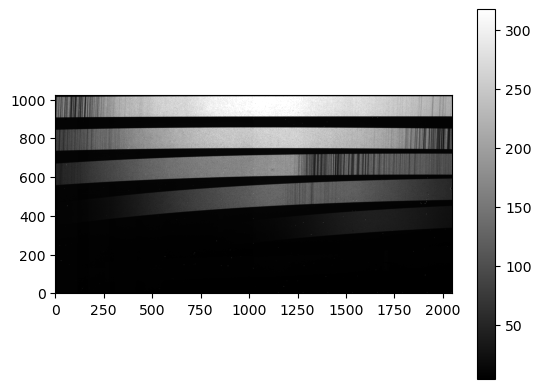

In [67]:
flat_data_on = []
for i in flat_table_on:
    flat_data_on.append((read_file(i["File"])) / i["exptime"])
flat_data_on = np.median(np.asarray(flat_data_on), axis=0)
flat_on = flat_data_on
plot_data(flat_on)

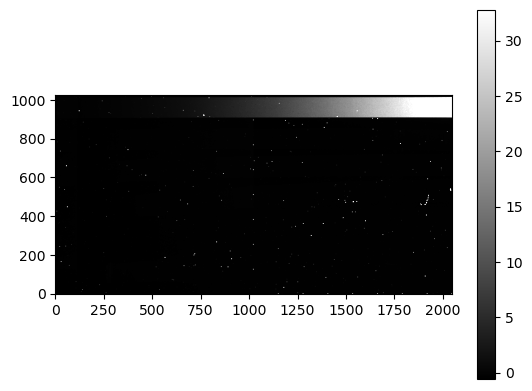

In [68]:
flat_data_off = []
for i in flat_table_off:
    flat_data_off.append((read_file(i["File"])) / i["exptime"])
flat_data_off = np.median(np.asarray(flat_data_off), axis=0)
flat_off = flat_data_off
plot_data(flat_off)

In [69]:
def find_cutoffs(x, minimum = 0.04):
    signal = np.where(x > minimum)[0]
    l_r = [signal[0]]
    for i in range(1 , len(signal)):
        prev_index = signal[i - 1]
        curr_index = signal[i]
        if((curr_index - prev_index) > 5):
            l_r.append(prev_index)
            l_r.append(curr_index)
    l_r.append(signal[-1])
    return l_r


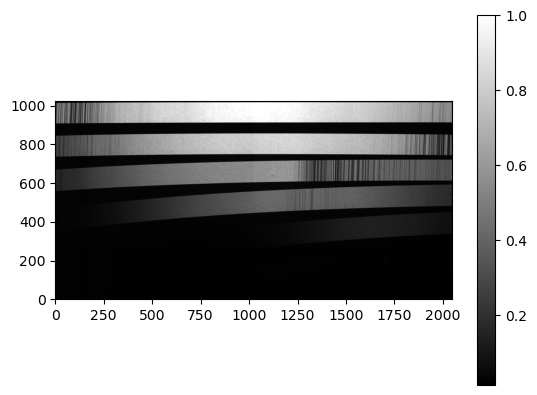

In [70]:
flat_counts = flat_on - flat_off
flat = flat_counts / np.percentile(flat_counts, 99)
plot_data(flat)
plt.show()

In [152]:
def read_file_flat(file_name, f = flat):
    return np.flip(fits.open(file_name)['PRIMARY'].data.astype(float), axis = 1)/f

In [72]:
flat.shape[1]

2048

In [73]:
cutoffs = []
for i in range(flat.shape[1]):
    cutoffs.append(find_cutoffs(flat[:,i]))
cutoffs = np.array(cutoffs)
cutoffs.shape

C:\Users\20xha\AppData\Local\Temp\ipykernel_40620\4224830578.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cutoffs = np.array(cutoffs)


(2048,)

In [74]:
twoam_std = standard[0:4]
threethrityam_std = standard[4:8]
fiveam_std = standard[8:12]

In [75]:
trace = Table.from_pandas(pd.read_csv("tspec_traces.csv"))
trace["order3_min"] = np.floor(trace["order3"] - slit_pixel_w/2).astype(int)
trace["order3_max"] = np.ceil(trace["order3"] + slit_pixel_w/2).astype(int)

In [92]:
def rectify(data, trace, slit_w, order):
    trace_line_min = np.floor(trace[order] - slit_w/2).astype(int)
    trace_line_max = trace_line_min + slit_w
    rectangle = []
    for i in range(data.shape[1]):
        column = data[:,i]
        rectangle.append(column[trace_line_min[i]:trace_line_max[i]])
    rectangle = np.asarray(rectangle)
    return rectangle.T

In [77]:
slit_pixel_w

81

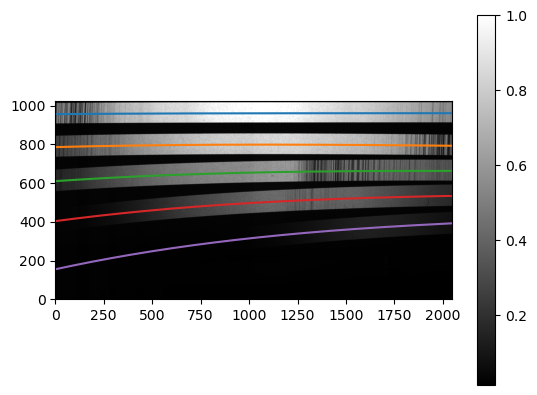

In [78]:
plot_data(flat)
plt.plot(range(2048), trace["order3"])
plt.plot(range(2048), trace["order4"])
plt.plot(range(2048), trace["order5"])
plt.plot(range(2048), trace["order6"])
plt.plot(range(2048), trace["order7"])

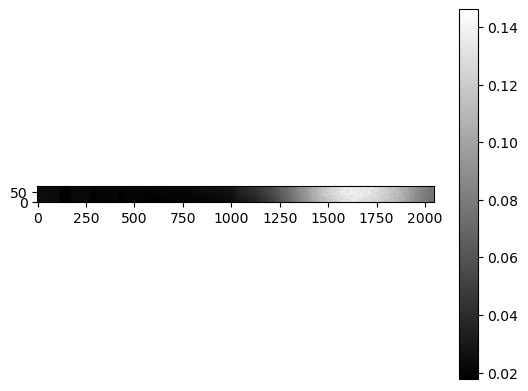

In [93]:
flat_rectify_order_3 = rectify(flat, trace, slit_pixel_w, "order7")
plot_data(flat_rectify_order_3)
plt.show()

In [82]:
def norm(data, flat):
    return data/flat

In [102]:
def AB_sub_flat(A, B, f = flat):
    return (A - B)/f

In [218]:
def ABBA_sub_flat(data, f = flat):
    return ((data[0] - data[1]) + (data[3] - data[2]))/f

In [153]:
def AB_sub(A, B):
    return (A - B)

In [178]:
twoam_std_data = []
for i in twoam_std:
    twoam_std_data.append((read_file(i["File"]) / i["exptime"]))
twoam_std_data = np.array(twoam_std_data)


C:\Users\20xha\AppData\Local\Temp\ipykernel_40620\2672243274.py:2: RuntimeWarning: divide by zero encountered in divide
  return (A - B)/f


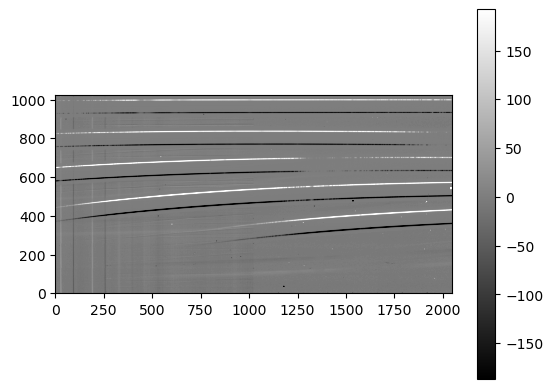

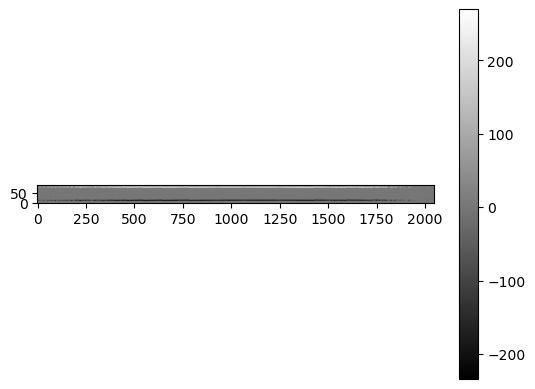

In [181]:
twoam_ab_data = AB_sub_flat(twoam_std_data[0], twoam_std_data[1])
plot_data(twoam_ab_data)
plt.show()
twoam_ab_data_7 = rectify(twoam_ab_data, trace, slit_pixel_w, "order4")
plot_data(twoam_ab_data_7)

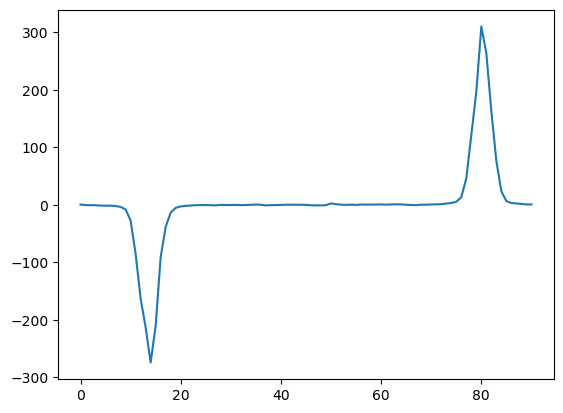

In [182]:
plt.plot(twoam_ab_data_7[:,1000])

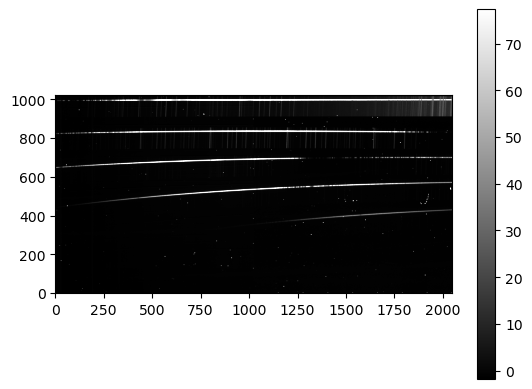

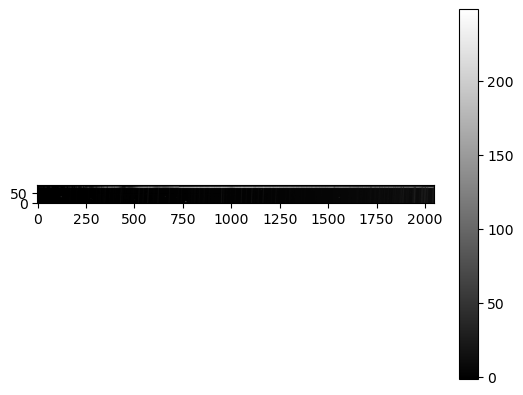

In [187]:
plot_data(twoam_std_data[0])
plt.show()
A_3 = rectify(twoam_std_data[0], trace, slit_pixel_w, "order3")
plot_data(A_3)

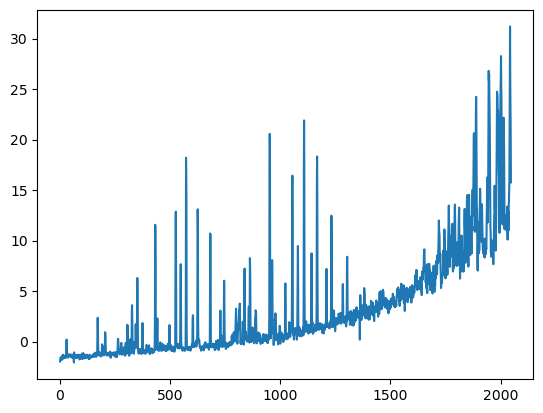

In [189]:
plt.plot(A_3[50])
#plt.yscale("log")

In [236]:
not_obs = Obslog[np.where("B" == Obslog["objid"])]
not_obs1 = not_obs[0:4]
not_obs2 = not_obs[4:8]
not_obs

File,Date,UTC,ra,dec,observer,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,str64,float64,float64,str64
./20230507\image0033.fits,127,08:34:32.3,18:31:16.23,+26:55:52.6,xanderberyl,B,1.237,300.0,object
./20230507\image0034.fits,127,08:40:09.6,18:31:17.54,+26:55:53.0,xanderberyl,B,1.219,300.0,object
./20230507\image0035.fits,127,08:45:45.6,18:31:17.53,+26:55:53.5,xanderberyl,B,1.202,300.0,object
./20230507\image0036.fits,127,08:51:23.7,18:31:16.23,+26:55:53.9,xanderberyl,B,1.186,300.0,object
./20230507\image0095.fits,127,11:33:55.0,18:31:16.31,+26:55:56.2,xanderberyl,B,1.008,300.0,object
./20230507\image0096.fits,127,11:39:33.5,18:31:17.60,+26:55:56.5,xanderberyl,B,1.009,300.0,object
./20230507\image0097.fits,127,11:45:09.6,18:31:17.59,+26:55:56.4,xanderberyl,B,1.011,300.0,object
./20230507\image0098.fits,127,11:50:47.6,18:31:16.32,+26:55:56.6,xanderberyl,B,1.013,300.0,object


In [198]:
def read_ABBA(table):
    data = []
    for i in table:
        data.append((read_file(i["File"]) / i["exptime"]))
    return np.array(data)

In [199]:
B2 = read_ABBA(not_obs2)

C:\Users\20xha\AppData\Local\Temp\ipykernel_40620\996342939.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((data[0] - data[1]) + (data[3] - data[2]))/f


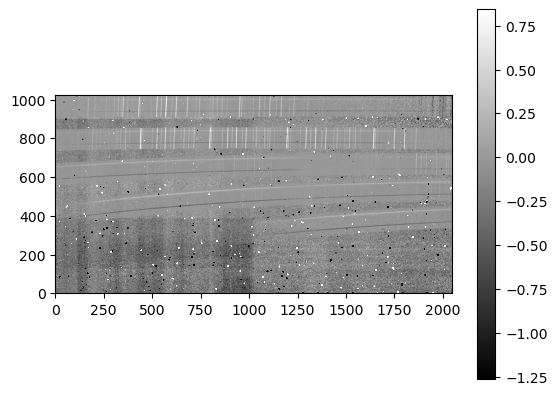

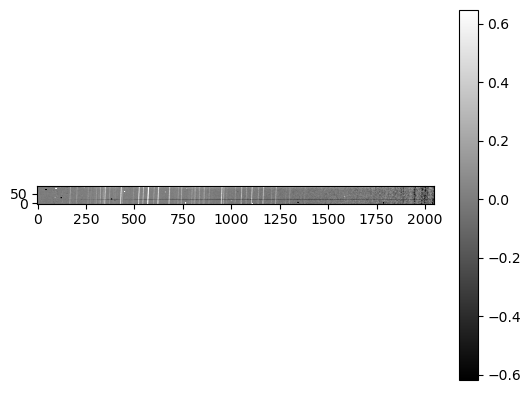

In [248]:
B2_reduced = ABBA_sub_flat(B2)
plot_data(B2_reduced)
plt.show()
B2_reduced_order3 = rectify(B2_reduced, trace, slit_pixel_w, "order3")
plot_data(B2_reduced_order3)

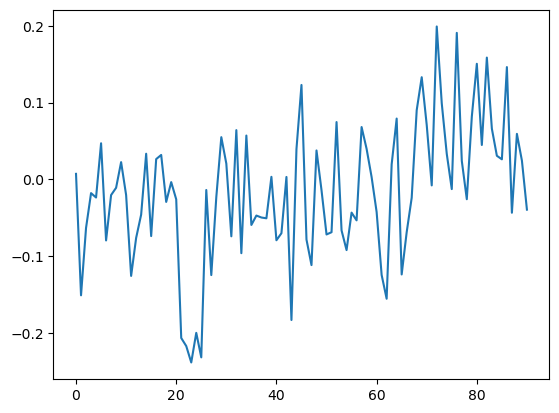

In [249]:
plt.plot(B2_reduced_order3[:,1000])

C:\Users\20xha\AppData\Local\Temp\ipykernel_40620\996342939.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((data[0] - data[1]) + (data[3] - data[2]))/f


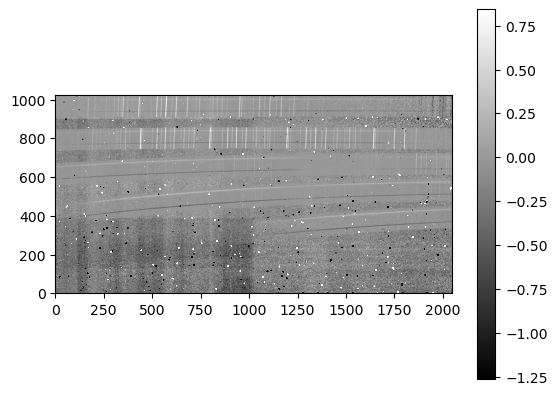

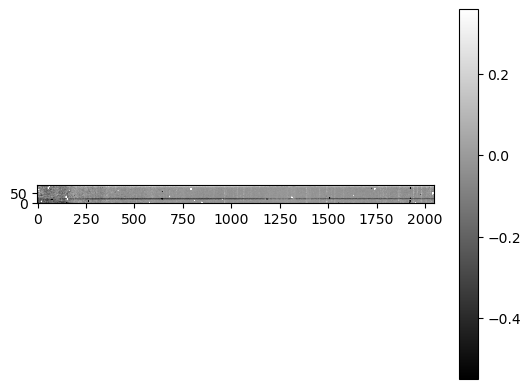

In [251]:
B1 = read_ABBA(not_obs2)
B1_reduced = ABBA_sub_flat(B1)
plot_data(B1_reduced)
plt.show()
B1_reduced_order4 = rectify(B1_reduced, trace, slit_pixel_w, "order6")
plot_data(B1_reduced_order4)

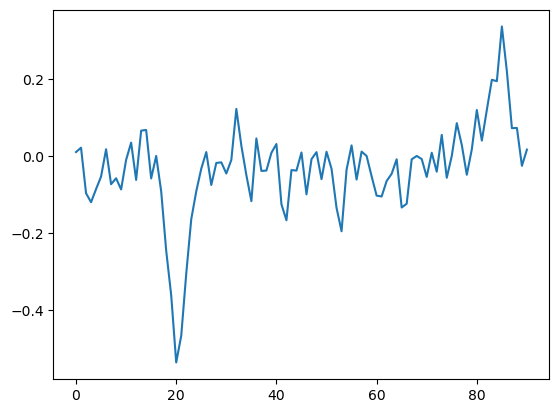

In [253]:
plt.plot(B1_reduced_order4[:,1000])

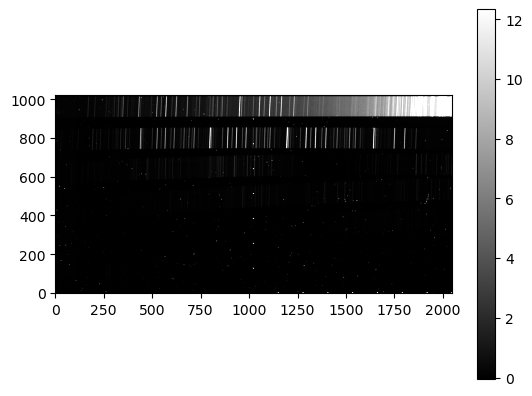

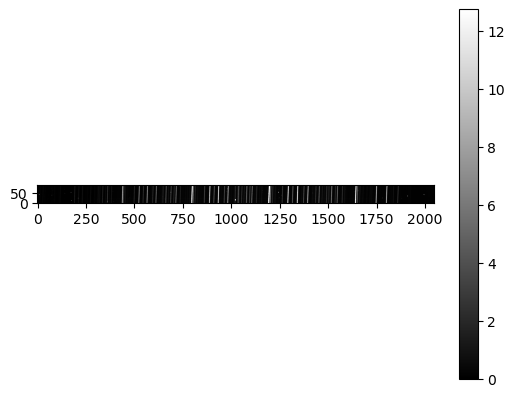

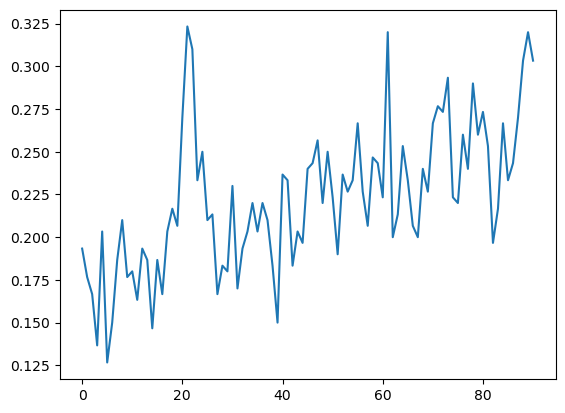

In [247]:
plot_data(B1[0])
plt.show()
B1_0_rec = rectify(B1[1], trace, slit_pixel_w, "order4")
plot_data(B1_0_rec)
plt.show()
plt.plot(B1_0_rec[:,750])